In [ ]:
import neptune

run = neptune.init_run(
    project="charlyrs/ysda-ner",
    api_token="!",
    capture_hardware_metrics=True,
    capture_stderr=True,
    capture_stdout=True,
)  

In [ ]:
run['parameters'] = { 'epoch': 20, 
                     'lr': 5e-5, 
                     'training-data': 'wnut_reddit2', 
                     'tokenizer': 'default' ,
                     'additional_info' : 'train_all_layers'
                      }

### Installations

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached datasets-2.11.0-py3-none-any.whl (468 kB)
  Using cached dill-0.3.6-py3-none-any.whl (110 kB)
  Using cached aiohttp-3.8.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 10.5 MB/s eta 0:00:00
  Using cached multiprocess-0.70.14-py39-none-any.whl (132 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 17.5 MB/s eta 0:00:00


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.28.1-py3-none-any.whl (7.0 MB)
  Using cached tokenizers-0.13.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.8 MB)


In [ ]:
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached seqeval-1.2.2.tar.gz (43 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=e20786d3f2e237f0d90c5ba25c7bd6b87c6cc33c1684192a0351c8517a2db489
  Stored in directory: /root/.cache/pip/wheels/e2/a5/92/2c80d1928733611c2747a9820e1324a6835524d9411510c142
Successfully built seqeval


In [ ]:
!pip install neptune

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.1 MB/s eta 0:00:00


### Imports

In [ ]:
import datasets
import typing as tp
from collections import defaultdict

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

In [ ]:
import torch.nn as nn

In [ ]:
from seqeval.metrics import classification_report, f1_score
from transformers import AutoTokenizer, BertForMaskedLM

In [ ]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import torch 
from tqdm.auto import tqdm

In [ ]:
from transformers import (pipeline, 
        AutoModelForTokenClassification, AutoTokenizer, 
        BertForTokenClassification, BertTokenizer)

In [ ]:
from torch.optim import AdamW
from IPython.display import clear_output
from transformers import get_scheduler

### Functions

In [ ]:
def convert_label_sequence(example: tp.Dict[str, tp.Any], label_mapping: tp.Dict[str, str]) -> tp.Dict[str, tp.Any]:
    converted_example = dict(**example)
    converted_example['ner_tags'] = [label_mapping[label] for label in example['ner_tags']]
    return converted_example

In [ ]:
def map_conll_labels_to_model(conll_label, conll_mapper, model_mapper):
    conll_inv_mapper = {v: k for k, v in conll_mapper.items()}
    text_label = conll_inv_mapper[conll_label]
    model_label = model_mapper[text_label]
    next_label = model_mapper[text_label.replace('B', 'I')]
    return model_label, next_label



def tokenize_and_preserve_tags(example: tp.Dict[str, tp.Any],
                               tokenizer: BertTokenizer,
                               label2id: tp.Dict[str, int],
                               tokenizer_params={}) -> tp.Dict[str, tp.Any]:
    # write your own function to split each pair of word-token to same number of pieces.
    encoded = tokenizer(example["tokens"], is_split_into_words=True, **tokenizer_params)
    encoded.update(example)

    labels = [0]
    for word, label in zip(example["tokens"], example["ner_tags"]):
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)
        label, next_label = map_conll_labels_to_model(label, conll_mapper, label2id)
        labels.append(label)
        labels += [next_label] * (n_subwords - 1)

    labels.append(0)
    encoded['labels'] = labels
    inv_map = {v: k for k, v in label2id.items()}
    encoded['text_labels'] = [inv_map[x] for x in encoded['labels']]
    assert len(encoded['labels']) == len(encoded["input_ids"])
    return encoded
    

In [ ]:
class PadSequence:
    def __init__(self, padded_columns, device='cuda'):
        self.padded_columns = set(padded_columns)
        self.device = device

    def __call__(self, batch):
        padded_batch = defaultdict(list)
        for example in batch:
            for key, tensor in example.items():
                padded_batch[key].append(tensor)
                
        for key, val in padded_batch.items():
            if key in self.padded_columns:
                padded_batch[key] = torch.nn.utils.rnn.pad_sequence(val, batch_first=True).to(self.device)
        return padded_batch

In [ ]:
class NamedEntityPredictor:
    def __init__(self,
                 model: BertForTokenClassification,
                 tokenizer: BertTokenizer,
                 id2label: tp.Optional[tp.Dict[str, int]] = None):
        self.model = model
        self.tokenizer = tokenizer
        self.id2label = model.config.id2label if id2label is None else id2label
    
    def predict(self, batch: tp.Dict[str, tp.Any], text=True):
        self.model.eval()
        with torch.no_grad():
            model_output = self.model(input_ids=batch["input_ids"],
                                      token_type_ids=batch["token_type_ids"],
                                      attention_mask=batch["attention_mask"],
                                      labels=batch["labels"],
                                      return_dict=True)
        indices = torch.argmax(model_output.logits, axis=2)
        indices = indices.detach().cpu().numpy()
        attention_mask = batch["attention_mask"].cpu().numpy()
        batch_size = len(batch["input_ids"])
        predicted_labels = []
        if text:
            for i in range(batch_size):
                predicted_labels.append([self.id2label[id_] for id_ in indices[i][attention_mask[i] == 1]])
        else:
            for i in range(batch_size):
                predicted_labels.append([id_ for id_ in indices[i][attention_mask[i] == 1]])
            
        return {
            "predicted_labels": predicted_labels,
            "loss": model_output.loss,
            "logits": model_output.logits
        }

In [ ]:
def predict(model, conll_loader, wnut_loader):
    ner = NamedEntityPredictor(model, tokenizer)
    predicted_labels = {"wnut_test": [], "conll_test": []}
    loss = {"wnut_test": [], "conll_test": []}
    for batch in tqdm(conll_loader):
        temp = ner.predict(batch)
        predicted_labels["conll_test"].extend(temp["predicted_labels"])
        loss['conll_test'].append(temp['loss'])
        
    for batch in tqdm(wnut_loader):
        temp = ner.predict(batch)
        predicted_labels["wnut_test"].extend(temp["predicted_labels"])
        loss['wnut_test'].append(temp['loss'])

    return predicted_labels, loss

def score_model(model, conll_loader, wnut_loader, conll, wnut):
    scores = {"wnut_test": {}, "conll_test": {}}
    predicted_labels, loss = predict(model, conll_loader, wnut_loader)
    scores['wnut_test']['f1'] = f1_score(y_true=[list(example["text_labels"]) for example in wnut],
                                       y_pred=predicted_labels["wnut_test"])
    
    scores['conll_test']['f1'] = f1_score(y_true=[list(example["text_labels"]) for example in conll],
                                                     y_pred=predicted_labels["conll_test"])
    scores['wnut_test']['loss'] = loss['wnut_test']
    scores['conll_test']['loss'] = loss['conll_test']
    return scores

In [ ]:
def get_sentence_embeddings(model, batch):
    model.eval()
    with torch.no_grad():
        out = model.bert(input_ids=batch["input_ids"],
                          token_type_ids=batch["token_type_ids"],
                          attention_mask=batch["attention_mask"],
                          return_dict=True)["last_hidden_state"].cpu().numpy()[:,0]
        return torch.cat((torch.Tensor(out), torch.Tensor(list(map(int,batch['id']))).view(-1,1)), dim=-1)

In [ ]:
def train(model, optimizer, scheduler, train_loader, conll, wnut, num_epochs=5, log_neptune=False):
    step = 0
    trigger_times = 0
    curr_wnut_f1 = 0
    prev_wnut_f1 = 0
    for epoch in range(num_epochs):
        model.train()
        for idx, batch in enumerate(tqdm(train_loader)):

            output = model(input_ids=batch["input_ids"],
                           token_type_ids=batch["token_type_ids"],
                           attention_mask=batch["attention_mask"],
                           labels=batch["labels"],
                           return_dict=True)
            loss = output.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            if log_neptune:
                run['train/loss'].append(loss)
                if step % 50 == 0:
                    conll_val_loader = torch.utils.data.DataLoader(conll['test'], 
                                                    batch_size=16, 
                                                    collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']))
                    wnut_val_loader = torch.utils.data.DataLoader(wnut['test'], 
                                                                      batch_size=16, 
                                                                      collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']))
                    conll_train_loader = torch.utils.data.DataLoader(conll['train'], 
                                                    batch_size=16, 
                                                    collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']))
                    wnut_train_loader = torch.utils.data.DataLoader(wnut['train'], 
                                                                      batch_size=16, 
                                                                      collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']))
                    scores_test = score_model(model, conll_val_loader, wnut_val_loader,conll['test'], wnut['test'])
                    f1_conll_test = scores_test['conll_test']['f1']
                    f1_wnut_test = scores_test['wnut_test']['f1']
                    scores_train = score_model(model, conll_train_loader, wnut_train_loader, conll['train'], wnut['train'])
                    f1_conll_train = scores_train['conll_test']['f1']
                    f1_wnut_train = scores_train['wnut_test']['f1']
                    run['val/f1_conll'].append(f1_conll_test)
                    run['val/f1_wnut'].append(f1_wnut_test)
                    run['val/loss_conll'].append(torch.mean(torch.Tensor(scores_test['conll_test']['loss'])))
                    run['val/loss_wnut'].append(torch.mean(torch.Tensor(scores_test['wnut_test']['loss'])))
                    run['train/f1_conll'].append(f1_conll_train)
                    run['train/f1_wnut'].append(f1_wnut_train)
                    #curr_wnut_f1 = f1_wnut_test
                    # if curr_wnut_f1 < prev_wnut_f1:
                    #     trigger_times += 1
                    #     print('trigger times:', trigger_times)
                    #     if trigger_times >= 3:
                    #         print('Early stopping!')
                    #         return
                    # else:
                    #     trigger_times = 0
                    #     prev_wnut_f1 = curr_wnut_f1


            step+=1

### Load data

In [ ]:
conll = datasets.load_dataset("conll2003")
wnut = datasets.load_dataset("wnut_17")

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3394 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1009 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1287 [00:00<?, ? examples/s]

Dataset wnut_17 downloaded and prepared to /root/.cache/huggingface/datasets/wnut_17/wnut_17/1.0.0/077c7f08b8dbc800692e8c9186cdf3606d5849ab0e7be662e6135bb10eba54f9. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
CONLL_NER_TAGS = conll['train'].features['ner_tags'].feature.names
WNUT_NER_TAGS = wnut['train'].features['ner_tags'].feature.names

In [ ]:
conll_mapper = dict(zip(CONLL_NER_TAGS, range(len(CONLL_NER_TAGS))))

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Label mapping

In [ ]:
label_mapping = {
    'O': 'O',
    'B-location': 'B-LOC',
    'I-location': 'I-LOC',
    'B-group': 'B-ORG',
    'B-corporation': 'B-ORG',
    'B-person': 'B-PER',
    'B-creative-work': 'B-MISC',
    'B-product': 'B-MISC',
    'I-person': 'I-PER',
    'I-creative-work': 'I-MISC',
    'I-corporation': 'I-ORG',
    'I-group': 'I-ORG',
    'I-product': 'I-MISC'
}

labelindexmapping = {WNUT_NER_TAGS.index(k):CONLL_NER_TAGS.index(v) for k, v in label_mapping.items()}

In [ ]:
converted_wnut = wnut.map(lambda x: convert_label_sequence(x, labelindexmapping))

Map:   0%|          | 0/3394 [00:00<?, ? examples/s]

Map:   0%|          | 0/1009 [00:00<?, ? examples/s]

Map:   0%|          | 0/1287 [00:00<?, ? examples/s]

### Load model

In [ ]:
model_name = 'dslim/bert-base-NER'
model = AutoModelForTokenClassification.from_pretrained(model_name, hidden_dropout_prob=0.2)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
conll = conll.map(lambda x: tokenize_and_preserve_tags(x, tokenizer, model.config.label2id))
wnut = converted_wnut
wnut = wnut.map(lambda x: tokenize_and_preserve_tags(x, tokenizer, model.config.label2id))

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Map:   0%|          | 0/3394 [00:00<?, ? examples/s]

Map:   0%|          | 0/1009 [00:00<?, ? examples/s]

Map:   0%|          | 0/1287 [00:00<?, ? examples/s]

In [ ]:
conll.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'], output_all_columns=True)
wnut.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'], output_all_columns=True)

### Fine-tuning

In [ ]:
# optional
for param in model.bert.parameters():
    param.requires_grad = False

In [ ]:
model.to(device)
wnut_train_dataloader = torch.utils.data.DataLoader(wnut["train"], 
                                                    batch_size=32, 
                                                    collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']))

num_epochs = 20
num_training_steps = num_epochs * len(wnut_train_dataloader)
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=5e-5)
scheduler = get_scheduler(
    name = 'linear',
    optimizer = optimizer,
    num_warmup_steps = 0,
    num_training_steps = num_training_steps)

In [ ]:
train(model, optimizer, scheduler,
      wnut_train_dataloader, conll, 
      wnut, num_epochs, log_neptune=True )

In [ ]:
run.stop()

### resampling methods

In [ ]:
def get_embeddings(model, conll, wnut, device=device):
    X = []
    Y = []
    model.to(device)
    conll_train_dataloader = torch.utils.data.DataLoader(conll["train"], batch_size=32, collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask']))
    wnut_train_dataloader = torch.utils.data.DataLoader(wnut["train"], batch_size=32, collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask']))

    for batch in tqdm(conll_train_dataloader):
        X.append(get_sentence_embeddings(model, batch))
        Y.extend([0] * len(batch["input_ids"]))
        
    for batch in tqdm(wnut_train_dataloader):
        X.append(get_sentence_embeddings(model, batch))
        Y.extend([1] * len(batch["input_ids"]))

    X = np.concatenate(X)
    Y = np.array(Y)
    return X, Y

In [ ]:
dataset_classifier = LogisticRegression(max_iter=1000)
X, Y = get_embeddings(model, conll, wnut, device=device)
kf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

  0%|          | 0/439 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

In [ ]:
def similar_samples(dataset_classifier, kf, X, Y, percent=0.25):
    samples_idx = []
    for i, (train_index, test_index) in enumerate(kf.split(X, Y)):
        # last column is index
        dataset_classifier.fit(X[train_index][:,:-1], Y[train_index])
        mask = Y[test_index] == 0
        prediction = dataset_classifier.predict_proba(X[test_index][:,:-1])[:,1]
        l = int(len(prediction) * percent)
        sorted_preds = np.argsort(prediction, axis=0)[::-1]
        samples_idx.extend(X[test_index][sorted_preds][mask][:l][:,-1])
    return samples_idx

In [ ]:
samples_idx = similar_samples(dataset_classifier, kf, X, Y)
data = [conll['train'][int(i)] for i in samples_idx]
loader = torch.utils.data.DataLoader(data,
                                     batch_size=32,
                                     collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']), 
                                     )

In [ ]:
from itertools import chain
from collections import Counter
tag_counts = Counter()
for sent in data:
    tag_counts.update(sent['ner_tags'])

<BarContainer object of 9 artists>

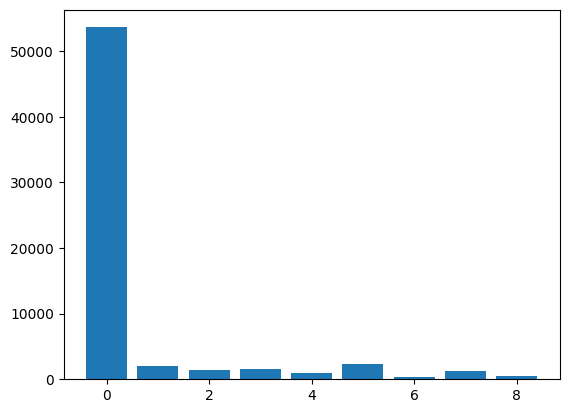

In [ ]:
plt.bar(tag_counts.keys(), tag_counts.values())

<BarContainer object of 8 artists>

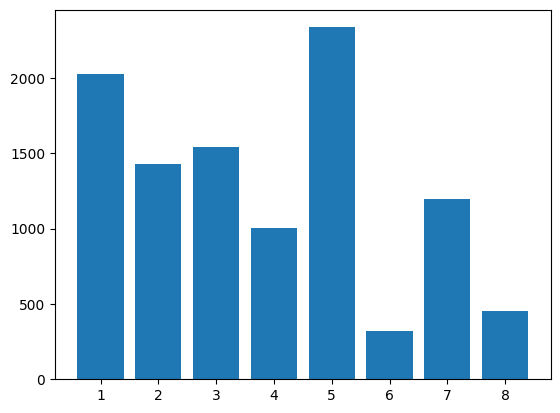

In [ ]:
plt.bar(list(tag_counts.keys())[1:], list(tag_counts.values())[1:])

In [ ]:
model.to(device)
num_epochs = 20
num_training_steps = num_epochs * len(loader)
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=1e-5)
scheduler = get_scheduler(
    name = 'linear',
    optimizer = optimizer,
    num_warmup_steps = 0,
    num_training_steps = num_training_steps)

In [ ]:
train(model, optimizer, scheduler,
      loader, conll, 
      wnut, num_epochs, log_neptune=True )

In [ ]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://new-ui.neptune.ai/charlyrs/ysda-ner/e/YSDAN-51/metadata


### proxy label

In [ ]:
ner = NamedEntityPredictor(model, tokenizer)

In [ ]:
wnut_train_dataloader = torch.utils.data.DataLoader(wnut["train"], 
                                                    shuffle=False,
                                                    batch_size=32, 
                                                    collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']))
model.to(device)
max_prediction = []
labels = []
sm = nn.Softmax(dim=-1)
for batch in tqdm(wnut_train_dataloader):
    predicted = ner.predict(batch, text=False)
    predicted_labels = predicted['predicted_labels']
    temp = sm(predicted["logits"])
    temp = np.array(temp.cpu())
    temp = np.max(temp[:,:,1:], axis=-1)
    temp = np.mean(temp, axis=-1)
    max_prediction.extend(temp)
    labels.extend(predicted_labels)
l = int(len(max_prediction) * 0.5)
data = np.argsort(max_prediction)[::-1][:l]

proxy_data = []
for i in data:
    temp = wnut['train'][int(i)]
    temp['labels'] = torch.Tensor(labels[i]).long()
    proxy_data.append(temp)

loader = torch.utils.data.DataLoader(proxy_data,
                                     batch_size=32,
                                     collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']), 
                                     )

  0%|          | 0/107 [00:00<?, ?it/s]

In [ ]:
from collections import Counter
tag_counts = Counter()
for sent in proxy_data:
    for t in sent['labels']:
      tag_counts[int(t)]+=1

<BarContainer object of 8 artists>

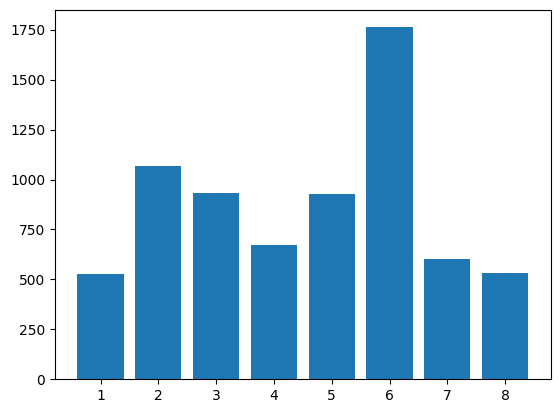

In [ ]:
plt.bar(list(tag_counts.keys())[1:], list(tag_counts.values())[1:])

In [ ]:
model.to(device)
num_epochs = 20
num_training_steps = num_epochs * len(loader)
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=1e-5)
scheduler = get_scheduler(
    name = 'linear',
    optimizer = optimizer,
    num_warmup_steps = 0,
    num_training_steps = num_training_steps)

In [ ]:
train(model, optimizer, scheduler,
      loader, conll, 
      wnut, num_epochs, log_neptune=True )

In [ ]:
run.stop()

### MLM reddit pre-training + fine-tuning

In [ ]:
#!wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/reddit_sample.json
reddit = datasets.load_dataset('json', data_files='reddit_sample.json')

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
def joiner(example: tp.Dict[str, tp.Any])-> tp.Dict[str, tp.Any]:
    global counter
    example['words'] = ' '.join(example['words'])
    example['id'] = counter
    counter += 1
    return example

In [ ]:
counter = 0 
reddit = reddit.map(lambda x: joiner(x))

In [ ]:
MAX_LENGTH = 50
def tokenize(reddit, tokenizer):
    def preprocess_function(examples):
        out = {}
        result = tokenizer(
            examples['words'],
            padding='max_length', max_length=MAX_LENGTH, truncation=True)
        out['input_ids'] = torch.Tensor(result['input_ids']).long()
        out['token_type_ids'] = torch.Tensor(result['token_type_ids']).long()
        out['attention_mask'] = torch.Tensor(result['attention_mask']).long()
        return out

    reddit_preprocessed = reddit.map(lambda x: preprocess_function(x), batched=True)
    return reddit_preprocessed

In [ ]:
reddit_prep = tokenize(reddit, tokenizer)

In [ ]:
reddit_prep.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask'], output_all_columns=True)

In [ ]:
dataset_classifier = LogisticRegression(max_iter=1000)
X, Y = get_embeddings(model, reddit_prep, wnut, device=device)
kf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

  0%|          | 0/15625 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

In [ ]:
#samples_idx = similar_samples(dataset_classifier, kf, X, Y, percent=0.1)
data = np.load('/content/drive/MyDrive/data/sample_idx.npy', allow_pickle=True)

In [ ]:
#data = [reddit_prep['train'][int(i)] for i in samples_idx]

In [ ]:
model = BertForMaskedLM.from_pretrained('dslim/bert-base-NER')
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForMaskedLM: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at dslim/bert-base-NER and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
You should probably TRAIN this model on a down-stream task 

In [ ]:
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

model.to(device)
training_args = TrainingArguments(
	output_dir = 'test_trainer_log',
	per_device_train_batch_size = 32,
	num_train_epochs = 2,
	report_to='none')

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=data,
)

In [ ]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,4.875400
1000,3.905600
1500,3.610700
2000,3.448800
2500,3.336000
3000,3.180600
3500,3.151700
4000,3.074400
4500,3.090300


TrainOutput(global_step=4720, training_loss=3.4959694555250267, metrics={'train_runtime': 1714.5747, 'train_samples_per_second': 88.074, 'train_steps_per_second': 2.753, 'total_flos': 3881430748572000.0, 'train_loss': 3.4959694555250267, 'epoch': 2.0})

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
model.save_pretrained('/content/drive/MyDrive/data/mlm')
model = AutoModelForTokenClassification.from_pretrained('/content/drive/MyDrive/data/mlm', hidden_dropout_prob=0.3)

Mounted at /content/drive/


In [ ]:
# optional
for param in model.bert.parameters():
    param.requires_grad = False

In [ ]:
model.to(device)
wnut_train_dataloader = torch.utils.data.DataLoader(wnut["train"], 
                                                    batch_size=32, 
                                                    collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']))

num_epochs = 20
num_training_steps = num_epochs * len(wnut_train_dataloader)
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=1e-3)
scheduler = get_scheduler(
    name = 'linear',
    optimizer = optimizer,
    num_warmup_steps = 0,
    num_training_steps = num_training_steps)

In [ ]:
train(model, optimizer, scheduler,
      wnut_train_dataloader, conll, 
      wnut, num_epochs, log_neptune=True )

In [ ]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://new-ui.neptune.ai/charlyrs/ysda-ner/e/YSDAN-66/metadata
